In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor

# Data Processing

In [3]:
train_X =pd.read_csv('train_X_cat.csv',index_col = 0)
train_y_sales =pd.read_csv('train_y_sales.csv')
train_y_sales = train_y_sales.sales
train_y_logsales =pd.read_csv('train_y_logsales.csv',index_col = 0)
train_y_logsales = train_y_logsales.sales

# Model Definition (Function)

Function is created to do k-fold (k=10) on the training data set based on different hyperparameters. Hyperparameters include the learning rate and n estimators.

In [3]:
from sklearn.model_selection import KFold
def Data_KFold_MSE(X,Y,k,alpha,n):
    kf = KFold(n_splits=k)
    test_mse = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        gbr = GradientBoostingRegressor(learning_rate=alpha, n_estimators=n, random_state = 8)
        gbr.fit(X_train, y_train)
        
        y_pred = gbr.predict(X_test)
        mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
        test_mse.append(mse)

    return np.mean(test_mse)

# Finding Best Hyperparameter

In [4]:
alpha = [0.001,0.01,0.1,1]
n_est = [10,100,1000]
MSE_logsales = []
for i in alpha:
    for r in n_est:
        MSE_logsales.append([i,r,Data_KFold_MSE(train_X, train_y_logsales,10,i,r)])
MSE_logsales

[[0.001, 10, 7142.998226578546],
 [0.001, 100, 6998.480755582214],
 [0.001, 1000, 4807.948063505493],
 [0.01, 10, 6997.6597463280295],
 [0.01, 100, 4793.7295440783255],
 [0.01, 1000, 907.326765424103],
 [0.1, 10, 4649.810825533643],
 [0.1, 100, 900.8407039909378],
 [0.1, 1000, 861.9283467509513],
 [1, 10, 1041.8583315775809],
 [1, 100, 1897.4164069733633],
 [1, 1000, 2106.5672490608185]]

In [5]:
length = len(MSE_logsales)
minimum = 100000
best = [0,0,0]
for i in range(length):
    if MSE_logsales[i][2] < minimum:
        minimum = MSE_logsales[i][2]
        best = MSE_logsales[i]
best

[0.1, 1000, 861.9283467509513]

In [6]:
# Based on the previous results, the best parameters are
# learning_rate = 0.1
# n_estimators = 1000
# This step will determine the best learning within the range of the learning rate found
alpha_logsales = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
MSE_logsales = []
for i in alpha_logsales:
    MSE_logsales.append(Data_KFold_MSE(train_X, train_y_logsales,10,i,1000))
MSE_logsales

[861.9283467509513,
 865.7243649379336,
 984.4036402185538,
 1034.718170239858,
 884.2942344010298,
 1165.4048266326736,
 1875.3227167696004,
 1549.7255122856748,
 1445.2728576988366]

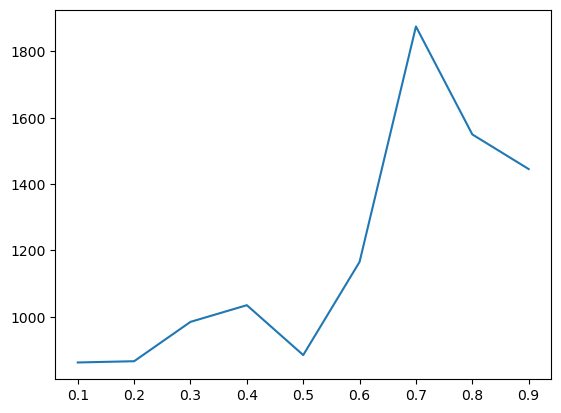

In [7]:
# Plotting the MSE values for the alpha values tested
plt.plot(alpha_logsales,MSE_logsales)
plt.show()

In [8]:
print(alpha_logsales[np.argmin(MSE_logsales)],MSE_logsales[np.argmin(MSE_logsales)])

0.1 861.9283467509513


Hence the best hyperparameter is:
1. Learning rate = 0.1
2. n estimator = 1000

Best MSE = 861.9283467509513

In [27]:
# Using the entire training data set to train the model for predicting
gbr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000, random_state = 8)
gbr.fit(train_X, train_y_logsales)

# Testing the MSE of the new model using only training data
y_pred = gbr.predict(train_X)
mse = mean_squared_error(np.exp(train_y_logsales), np.exp(y_pred)) 
mse

34.15950255253834

# Inventory Decision

Model processing for inventory decision

In [28]:
# splitting the training set to get the validation set (0.2)
from sklearn.model_selection import train_test_split
X_train1,X_test1,Y_train1,Y_test1 = train_test_split(train_X,train_y_logsales,test_size=0.2,random_state=8)

#Retraining the model using the the best hyperparameters determined, random state fixed at 8
Model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000,random_state = 8)
Model.fit(X_train1,Y_train1.values.ravel())
result = pd.DataFrame(Y_test1)
result['predicted sales'] = Model.predict(X_test1)

#Calculation of residual for validation set
resid = np.exp(result['sales']) - np.exp(result['predicted sales'])

In [29]:
# finding the critical fractile for the residual distribution
price = 20
cost = 12
salvage = 8
Overage_cost = cost - salvage
Underage_cost = price - cost
critical_fractile = Underage_cost/(Overage_cost + Underage_cost)

# QQ Plot
Using QQ plot to determine the distribution of the residual of the prediction of the model.

In [30]:
import scipy
import scipy.stats as sct

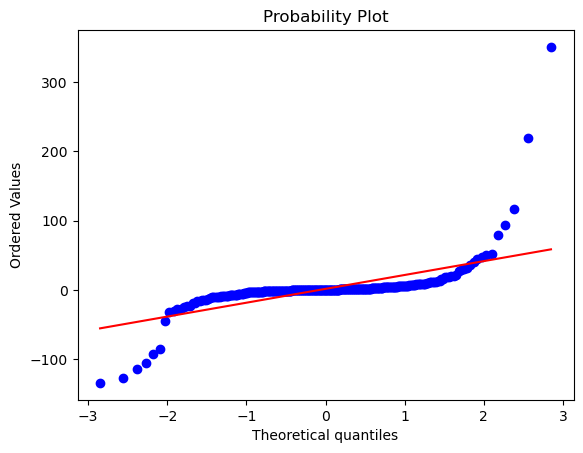

In [31]:
#Normal distribution
scipy.stats.probplot(resid, dist="norm", plot=plt)
plt.show()

In [32]:
# To find the values, it is the sum of the mean and the standard deviation multipled 
# by the standard normal distribution of the critical fractile
norm_std = resid.std()
demand_values_normal=round(sct.norm.ppf(critical_fractile)*norm_std + np.exp(result['predicted sales']))
demand_values_normal

117     65.0
193     24.0
355     22.0
766     15.0
550     19.0
        ... 
1357    14.0
384     50.0
993     32.0
176     15.0
257     15.0
Name: predicted sales, Length: 316, dtype: float64

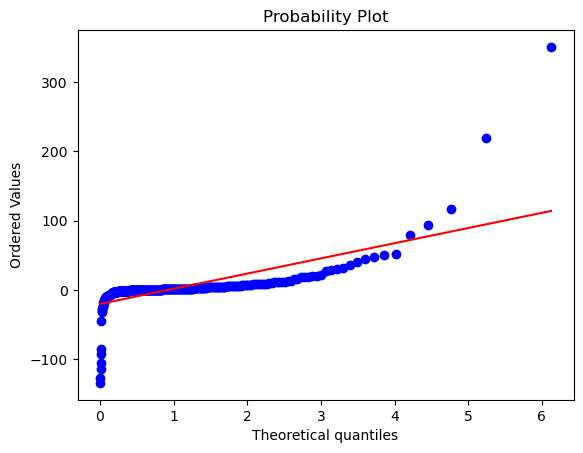

In [33]:
# Exponential Distribution
scipy.stats.probplot(resid, dist="expon", plot=plt)
plt.show()

In [34]:
# to find the demand values for exponential, require to use the inverse of the exponential distribution
demand_values_exp = round(-(np.exp(result['predicted sales']))*np.log(1-critical_fractile))
demand_values_exp

117     57.0
193     11.0
355      9.0
766      1.0
550      6.0
        ... 
1357     1.0
384     41.0
993     20.0
176      1.0
257      1.0
Name: predicted sales, Length: 316, dtype: float64

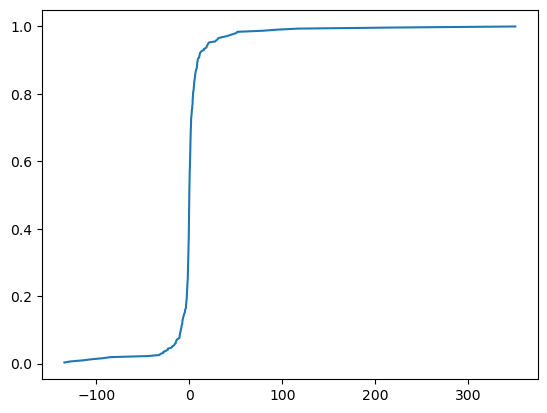

In [35]:
# Empirical Distribution
steps = 1/resid.shape[0]
jump = [steps*i for i in range(1,resid.shape[0]+1)]
samples = sorted(resid)
plt.plot(samples,jump)

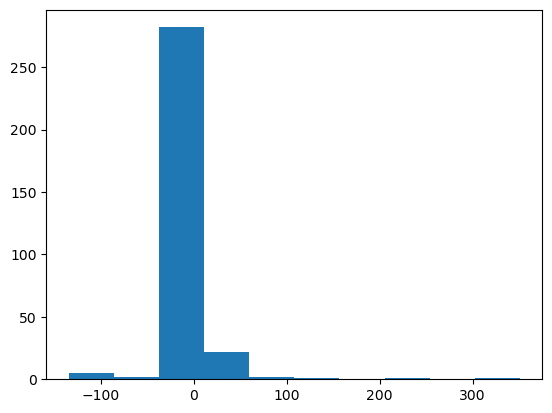

In [36]:
plt.hist(samples)
plt.show()

In [37]:
# Finding the inverse of the empricial distribution based on the critical fractile
def inv_of_dis(sample, jump, crit):
    current_step = 0
    checking_value = jump[current_step]
    while checking_value < crit:
        current_step += 1
        checking_value = jump[current_step]
    return sample[current_step]

In [38]:
demand_values_em = np.exp(result['predicted sales']) + inv_of_dis(samples, jump, critical_fractile)
demand_values_em

117     53.239310
193     11.436665
355      9.647301
766      2.461629
550      6.567878
          ...    
1357     2.360119
384     38.377359
993     19.580712
176      2.604181
257      2.515708
Name: predicted sales, Length: 316, dtype: float64

# Out-of-Sample Profit

In [39]:
# Finding the max profit based on the test set.
# No salvage as all products will be sold
max_profit = np.exp(result['sales']).sum()*(price-cost)
max_profit

97448.0

In [40]:
# Finding profit for the different distributions for the residual
# Create a profit function.
def profit(demand,y):
    return (price-salvage)*np.minimum(demand,y) - (cost-salvage)*y

# For this, demand will take on the actual sales while y will take on the predicted sales

In [41]:
# no distribution included
np.sum(profit(np.exp(result['sales']),round(np.exp(result['predicted sales']))))

77292.0

In [42]:
# normal distribution included
np.sum(profit(np.exp(result['sales']),round(demand_values_normal)))

69236.0

In [43]:
# exponential distribution included
np.sum(profit(np.exp(result['sales']),round(demand_values_exp)))

78620.0

In [44]:
# empricial distribution included
np.sum(profit(np.exp(result['sales']),round(demand_values_em)))

77684.0

# K Fold Cross Validation for the Inventory Decision

In [45]:
def K_fold_inventory_decision(X,Y,k):
    best_profit = []
    profit_non = []
    profit_normal = []
    profit_exp = []
    profit_em = []
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        #Retraining the model
        Model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000,random_state = 8)
        Model.fit(X_train,y_train.values.ravel())
        
        result = pd.DataFrame(y_test)
        result['predicted sales'] = Model.predict(X_test)
        
        #Calculation of residual
        resid = np.exp(result['sales']) - np.exp(result['predicted sales'])
        
        # Testing normal distribution for residual
        norm_std = resid.std()
        demand_values_normal=round(sct.norm.ppf(critical_fractile)*norm_std + np.exp(result['predicted sales']))
        
        # Testing exponential distribution for residual
        demand_values_exp = round(-(np.exp(result['predicted sales']))*np.log(1-critical_fractile))
        
        # Testing empirical distribution for residual
        steps = 1/resid.shape[0]
        jump = [steps*i for i in range(1,resid.shape[0]+1)]
        samples = sorted(resid)
        demand_values_em = np.exp(result['predicted sales']) + inv_of_dis(samples, jump, critical_fractile)
        
        max_profit = np.exp(result['sales']).sum()*(price-cost)
        best_profit.append(max_profit)
        
        profit_non.append(np.sum(profit(np.exp(result['sales']),round(np.exp(result['predicted sales'])))))
        profit_normal.append(np.sum(profit(np.exp(result['sales']),round(demand_values_normal))))
        profit_exp.append(np.sum(profit(np.exp(result['sales']),round(demand_values_exp))))
        profit_em.append(np.sum(profit(np.exp(result['sales']),round(demand_values_em))))
    return best_profit, profit_non, profit_normal, profit_exp, profit_em

In [46]:
data = K_fold_inventory_decision(train_X,train_y_logsales,10)

In [47]:
# Comparing different profits based on different distributions
print("Max profit average", np.average(data[0]))
print("Profit with no distribution average", np.average(data[1]))
print("Profit with normal distribution average", np.average(data[2]))
print("Profit with exponential distribution average", np.average(data[3]))
print("Profit with empirical distribution average", np.average(data[4]))

Max profit average 43742.4
Profit with no distribution average 34870.4
Profit with normal distribution average 31321.6
Profit with exponential distribution average 35396.4
Profit with empirical distribution average 35029.6


Based on the outcome of the k fold for inventory decision, the best distribution to model the residual of the sales is an exponential distribution as it is able to give the highest profit. However, if the random state, were to change, there are cases where the empirical distribution gives the highest profit.